In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
dfParticipants = pd.read_csv("R-SED_data/participants.csv", delimiter=",", index_col=0)

In [3]:
dfJudgements = pd.read_csv("R-SED_data/triplet_judgements.csv", delimiter=",", index_col=0)

In [4]:
dfTriplets = pd.read_csv("R-SED_data/triplets.csv", delimiter=",", index_col=0)

In [5]:
dfAll = dfParticipants.join(dfJudgements.reset_index().set_index("user_id"), how="inner")
dfAll = dfAll.reset_index().set_index("triplet_id").join(dfTriplets, how="inner").reset_index().set_index("judgement_id")
dfAll.head(3)

,triplet_id,user_id,age_group,education,ml_expert,choice,simplified_choice,option_one_path,option_two_path,time_spent,handheld,window_width,window_height,user_agent,model,target_path,candidate1_path,candidate2_path,candidate1_bin,candidate2_bin,W2VVExtractor_cosdist_query_candidate1,W2VVExtractor_cosdist_query_candidate2,W2VVExtractor_cosdist_candidates,W2VVExtractor_eucldist_query_candidate1,W2VVExtractor_eucldist_query_candidate2,W2VVExtractor_eucldist_candidates,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate1,CIELABPositionalExctractor_regions_2x2_cosdist_query_candidate2,CIELABPositionalExctractor_regions_2x2_cosdist_candidates,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate1,CIELABPositionalExctractor_regions_2x2_eucldist_query_candidate2,CIELABPositionalExctractor_regions_2x2_eucldist_candidates,VLADExctractor__cosdist_query_candidate1,VLADExctractor__cosdist_query_candidate2,VLADExctractor__cosdist_candidates,VLADExctractor__eucldist_query_candidate1,VLADExctractor__eucldist_query_candidate2,VLADExctractor__eucldist_candidates,RGBHistogramExtractor_256_cosdist_query_candidate1,RGBHistogramExtractor_256_cosdist_query_candidate2,RGBHistogramExtractor_256_cosdist_candidates,RGBHistogramExtractor_256_eucldist_query_candidate1,RGBHistogramExtractor_256_eucldist_query_candidate2,RGBHistogramExtractor_256_eucldist_candidates,ConvNeXTExtractor_tiny_cosdist_query_candidate1,ConvNeXTExtractor_tiny_cosdist_query_candidate2,ConvNeXTExtractor_tiny_cosdist_candidates,ConvNeXTExtractor_tiny_eucldist_query_candidate1,ConvNeXTExtractor_tiny_eucldist_query_candidate2,ConvNeXTExtractor_tiny_eucldist_candidates,ViTExtractor_base_cosdist_query_candidate1,ViTExtractor_base_cosdist_query_candidate2,ViTExtractor_base_cosdist_candidates,ViTExtractor_base_eucldist_query_candidate1,ViTExtractor_base_eucldist_query_candidate2,ViTExtractor_base_eucldist_candidates,EfficientNetExtractor_0_cosdist_query_candidate1,EfficientNetExtractor_0_cosdist_query_candidate2,EfficientNetExtractor_0_cosdist_candidates,EfficientNetExtractor_0_eucldist_query_candidate1,EfficientNetExtractor_0_eucldist_query_candidate2,EfficientNetExtractor_0_eucldist_candidates,ConvNeXTExtractor_small_cosdist_query_candidate1,ConvNeXTExtractor_small_cosdist_query_candidate2,ConvNeXTExtractor_small_cosdist_candidates,ConvNeXTExtractor_small_eucldist_query_candidate1,ConvNeXTExtractor_small_eucldist_query_candidate2,ConvNeXTExtractor_small_eucldist_candidates,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate1,CIELABPositionalExctractor_regions_4x4_cosdist_query_candidate2,CIELABPositionalExctractor_regions_4x4_cosdist_candidates,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate1,CIELABPositionalExctractor_regions_4x4_eucldist_query_candidate2,CIELABPositionalExctractor_regions_4x4_eucldist_candidates,EfficientNetExtractor_4_cosdist_query_candidate1,EfficientNetExtractor_4_cosdist_query_candidate2,EfficientNetExtractor_4_cosdist_candidates,EfficientNetExtractor_4_eucldist_query_candidate1,EfficientNetExtractor_4_eucldist_query_candidate2,EfficientNetExtractor_4_eucldist_candidates,ConvNeXTExtractor_base_cosdist_query_candidate1,ConvNeXTExtractor_base_cosdist_query_candidate2,ConvNeXTExtractor_base_cosdist_candidates,ConvNeXTExtractor_base_eucldist_query_candidate1,ConvNeXTExtractor_base_eucldist_query_candidate2,ConvNeXTExtractor_base_eucldist_candidates,RGBHistogramExtractor_64_cosdist_query_candidate1,RGBHistogramExtractor_64_cosdist_query_candidate2,RGBHistogramExtractor_64_cosdist_candidates,RGBHistogramExtractor_64_eucldist_query_candidate1,RGBHistogramExtractor_64_eucldist_query_candidate2,RGBHistogramExtractor_64_eucldist_candidates,CLIPExtractor_medium_cosdist_query_candidate1,CLIPExtractor_medium_cosdist_query_candidate2,CLIPExtractor_medium_cosdist_candidates,CLIPExtractor_medium_eucldist_query_candidate1,CLIPExtractor_medium_eucldist_query_candidate2,CLIPExtractor_medium_eucldist_candidates,VANExtractor_base_cosdist_

# Simplified judgement analysis
- focusing only on whether left or right choice was more similar
- ignoring indifferent judgements as well as magnitude of user's judgement
- analysis is limited to cosine distance

## Pre-processing data, assessing consistency w.r.t. individual extractors

In [6]:
extractors = dfAll.model.unique()
extractors.sort()
extractors

array(['CIELABKMeansExctractor_4',
       'CIELABPositionalExctractor_regions_2x2',
       'CIELABPositionalExctractor_regions_4x4',
       'CIELABPositionalExctractor_regions_8x8', 'CLIPExtractor_medium',
       'CLIPExtractor_small', 'ConvNeXTExtractor_base',
       'ConvNeXTExtractor_large', 'ConvNeXTExtractor_small',
       'ConvNeXTExtractor_tiny', 'EfficientNetExtractor_0',
       'EfficientNetExtractor_2', 'EfficientNetExtractor_4',
       'EfficientNetExtractor_6', 'EfficientNetExtractor_7',
       'ImageGPTExtractor_medium', 'ImageGPTExtractor_small',
       'RGBHistogramExtractor_256', 'RGBHistogramExtractor_64',
       'ResNetV2Extractor_101', 'ResNetV2Extractor_152',
       'ResNetV2Extractor_50', 'VANExtractor_base', 'VANExtractor_large',
       'VANExtractor_small', 'VANExtractor_tiny', 'VLADExctractor_',
       'ViTExtractor_base', 'ViTExtractor_large', 'W2VVExtractor'],
      dtype=object)

In [7]:
extractors.shape

(30,)

In [8]:
dfAll["candidate1DisplayedOnLeft"] = (dfAll["option_one_path"] == dfAll["candidate1_path"])

In [9]:
columnsToDrop = []
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    col1e = extractor+"_eucldist_query_candidate1"
    col2e = extractor+"_eucldist_query_candidate2"
    opt = extractor+"_eucldist_candidates"
    #dealing with the fact that either of candidate1 and candidate2 can be displayed as left/right option
    dfAll[extractor+"_option_left_dist"] = dfAll[col2]
    dfAll[extractor+"_option_right_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_left_dist"] = dfAll[col1]
    dfAll.loc[dfAll["candidate1DisplayedOnLeft"],extractor+"_option_right_dist"] = dfAll[col2]
    
    #assessing consistency of the model with human judgement
    right_option_better = ((dfAll[extractor+"_option_left_dist"] > dfAll[extractor+"_option_right_dist"]))
    dfAll["better_for_"+extractor] = right_option_better.astype(int) * 2 - 1
    
    dfAll["same_as_model_"+extractor] = dfAll["simplified_choice"] == dfAll["better_for_"+extractor]
    
    #cleaning the data frame
    columnsToDrop.extend([col1,col2,col1e,col2e,opt])    
dfConsistency = dfAll.drop(columnsToDrop,axis=1)   
dfConsistency.head(3)

,triplet_id,user_id,age_group,education,ml_expert,choice,simplified_choice,option_one_path,option_two_path,time_spent,handheld,window_width,window_height,user_agent,model,target_path,candidate1_path,candidate2_path,candidate1_bin,candidate2_bin,W2VVExtractor_cosdist_candidates,CIELABPositionalExctractor_regions_2x2_cosdist_candidates,VLADExctractor__cosdist_candidates,RGBHistogramExtractor_256_cosdist_candidates,ConvNeXTExtractor_tiny_cosdist_candidates,ViTExtractor_base_cosdist_candidates,EfficientNetExtractor_0_cosdist_candidates,ConvNeXTExtractor_small_cosdist_candidates,CIELABPositionalExctractor_regions_4x4_cosdist_candidates,EfficientNetExtractor_4_cosdist_candidates,ConvNeXTExtractor_base_cosdist_candidates,RGBHistogramExtractor_64_cosdist_candidates,CLIPExtractor_medium_cosdist_candidates,VANExtractor_base_cosdist_candidates,ResNetV2Extractor_101_cosdist_candidates,ResNetV2Extractor_152_cosdist_candidates,EfficientNetExtractor_7_cosdist_candidates,ImageGPTExtractor_medium_cosdist_candidates,ResNetV2Extractor_50_cosdist_candidates,ConvNeXTExtractor_large_cosdist_candidates,EfficientNetExtractor_2_cosdist_candidates,CLIPExtractor_small_cosdist_candidates,VANExtractor_large_cosdist_candidates,ViTExtractor_large_cosdist_candidates,VANExtractor_small_cosdist_candidates,ImageGPTExtractor_small_cosdist_candidates,EfficientNetExtractor_6_cosdist_candidates,VANExtractor_tiny_cosdist_candidates,CIELABKMeansExctractor_4_cosdist_candidates,CIELABPositionalExctractor_regions_8x8_cosdist_candidates,class,candidate1DisplayedOnLeft,CIELABKMeansExctractor_4_option_left_dist,CIELABKMeansExctractor_4_option_right_dist,better_for_CIELABKMeansExctractor_4,same_as_model_CIELABKMeansExctractor_4,CIELABPositionalExctractor_regions_2x2_option_left_dist,CIELABPositionalExctractor_regions_2x2_option_right_dist,better_for_CIELABPositionalExctractor_regions_2x2,same_as_model_CIELABPositionalExctractor_regions_2x2,CIELABPositionalExctractor_regions_4x4_option_left_dist,CIELABPositionalExctractor_regions_4x4_option_right_dist,better_for_CIELABPositionalExctractor_regions_4x4,same_as_model_CIELABPositionalExctractor_regions_4x4,CIELABPositionalExctractor_regions_8x8_option_left_dist,CIELABPositionalExctractor_regions_8x8_option_right_dist,better_for_CIELABPositionalExctractor_regions_8x8,same_as_model_CIELABPositionalExctractor_regions_8x8,CLIPExtractor_medium_option_left_dist,CLIPExtractor_medium_option_right_dist,better_for_CLIPExtractor_medium,same_as_model_CLIPExtractor_medium,CLIPExtractor_small_option_left_dist,CLIPExtractor_small_option_right_dist,better_for_CLIPExtractor_small,same_as_model_CLIPExtractor_small,ConvNeXTExtractor_base_option_left_dist,ConvNeXTExtractor_base_option_right_dist,better_for_ConvNeXTExtractor_base,same_as_model_ConvNeXTExtractor_base,ConvNeXTExtractor_large_option_left_dist,ConvNeXTExtractor_large_option_right_dist,better_for_ConvNeXTExtractor_large,same_as_model_ConvNeXTExtractor_large,ConvNeXTExtractor_small_option_left_dist,ConvNeXTExtractor_small_option_right_dist,better_for_ConvNeXTExtractor_small,same_as_model_ConvNeXTExtractor_small,ConvNeXTExtractor_tiny_option_left_dist,ConvNeXTExtractor_tiny_option_right_dist,better_for_ConvNeXTExtractor_tiny,same_as_model_ConvNeXTExtractor_tiny,EfficientNetExtractor_0_option_left_dist,EfficientNetExtractor_0_option_right_dist,better_for_EfficientNetExtractor_0,same_as_model_EfficientNetExtractor_0,EfficientNetExtractor_2_option_left_dist,EfficientNetExtractor_2_option_right_dist,better_for_EfficientNetExtractor_2,same_as_model_EfficientNetExtractor_2,EfficientNetExtractor_4_option_left_dist,EfficientNetExtractor_4_option_right_dist,better_for_EfficientNetExtractor_4,same_as_model_EfficientNetExtractor_4,EfficientNetExtractor_6_option_left_dist,EfficientNetExtractor_6_option_right_dist,better_for_EfficientNetExtractor_6,same_as_model_EfficientNetExtractor_6,EfficientNetExtractor_7_option_left_dist,EfficientNetExtractor_7_option_right_dist,better_for_EfficientNetExtractor_7,

In [10]:
dfConsistencyNonUnknown = dfConsistency.loc[dfConsistency.simplified_choice!=0]

## Evaluation variant 1: all user judgement decisions count equally

In [11]:
extrNames = []
scores = []
for extractor in extractors:
    name = "same_as_model_"+extractor
    extrNames.extend([extractor]*dfConsistencyNonUnknown.shape[0])
    scores.extend(dfConsistencyNonUnknown[name].values.tolist())  
dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
dfScores.head(3)

,Extractor,consistent
0,CIELABKMeansExctractor_4,True
1,CIELABKMeansExctractor_4,True
2,CIELABKMeansExctractor_4,True


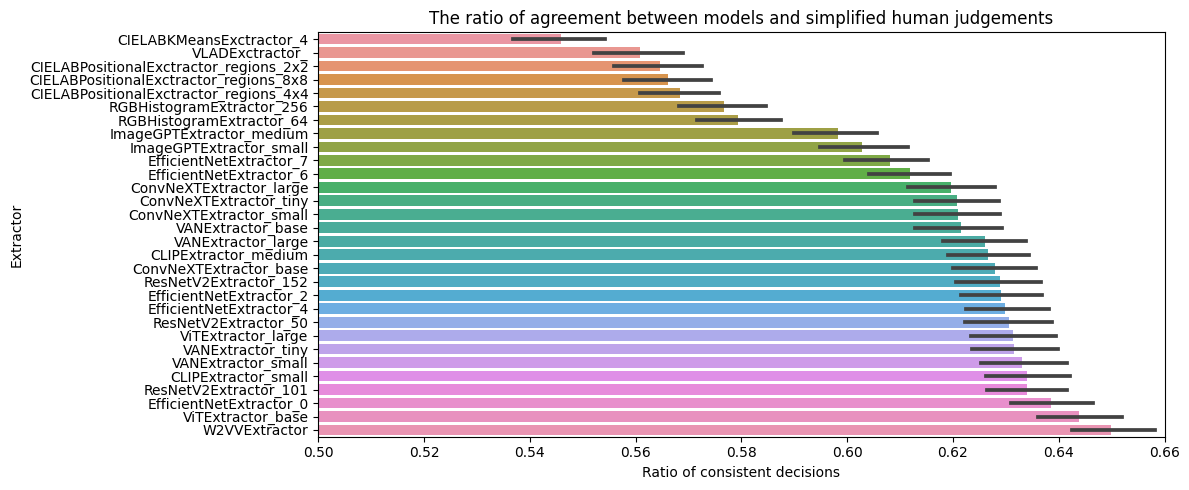

In [12]:
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScores
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.5,0.66)

plt.tight_layout()
plt.savefig("img/overall_consistentRatio.pdf")
plt.show()

Notable points:
- W2VV still best-performing, consistent with the preliminary study
- Quite often, smaller DL models of the same architecture perform better than the larger ones (e.g., EfficientNet)
- Overall, deep learning variants outperform shallow color-based and texture-based embeddings
- All extractor performed better than random guessing
- However, in general, the judgement consistency is rather weak

In [13]:
extractorsOrder = dfScores.groupby("Extractor")["consistent"].sum().sort_values().index
best_model = extractorsOrder[-1]
worst_model = extractorsOrder[0]
mid_model = extractorsOrder[extractorsOrder.shape[0]//2]
worst_model

'CIELABKMeansExctractor_4'

In [14]:
top_models = extractorsOrder[-3:].tolist()

## Evaluation variant 2: each aggregated per-triplet decision counts equally
- only triplets with 3+ judgements kept

In [15]:
minJudgements = 3

tripletCounts = dfAll.groupby("triplet_id")["user_id"].count()
tripletCounts = tripletCounts.loc[tripletCounts >= minJudgements]
tripletCounts.shape

(2138,)

In [16]:
dfReduced = dfAll.loc[dfAll.triplet_id.isin(tripletCounts.index)].copy()

- differences in positioning of candidates 1 and 2 for individual judgements has to be settled

In [17]:
sideOfCandidate1 = ((dfReduced.candidate1DisplayedOnLeft.astype(int)+1) % 2) *2-1

dfReduced["candidate1_preference"] = (sideOfCandidate1 == dfReduced.simplified_choice).astype(int)
dfReduced["candidate2_preference"] = (-sideOfCandidate1 == dfReduced.simplified_choice).astype(int)

dfTripletAgg = dfReduced.groupby("triplet_id").mean()
dfTripletAgg["candidate_choice"] = dfTripletAgg.candidate2_preference - dfTripletAgg.candidate1_preference
print(dfTripletAgg.shape)
dfTripletAgg = dfTripletAgg.loc[dfTripletAgg.candidate_choice!=0]
dfTripletAgg.candidate_choice = np.sign(dfTripletAgg.candidate_choice)
print(dfTripletAgg.shape)

(2138, 313)
(1948, 313)


- in about 10% of cases, aggregated judgements do not tend to prefer either option

In [18]:
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    dfTripletAgg["better_for_"+extractor] = (dfTripletAgg[col2] < dfTripletAgg[col1]).astype(int) * 2 - 1
    
    dfTripletAgg["same_as_model_"+extractor] = dfTripletAgg["candidate_choice"] == dfTripletAgg["better_for_"+extractor]

In [19]:
extrNames = []
scores = []
for extractor in extractors:
    name = "same_as_model_"+extractor
    extrNames.extend([extractor]*dfTripletAgg.shape[0])
    scores.extend(dfTripletAgg[name].values.tolist())  
dfScores = pd.DataFrame({"Extractor":extrNames,"consistent":scores})
dfScores.head(3)

,Extractor,consistent
0,CIELABKMeansExctractor_4,False
1,CIELABKMeansExctractor_4,True
2,CIELABKMeansExctractor_4,True


### Level of human agreement

In [20]:
agreements = 0
trials = 0
triplet_wise_agreement = []

dfReducedNoEq = dfReduced.loc[dfReduced.choice!=0]
for tid in dfReducedNoEq.triplet_id.unique():
    uids = dfReducedNoEq.loc[dfReducedNoEq.triplet_id == tid, "user_id"].unique()
    t_agreements = 0
    t_trials = 0
    for i in uids:
        for j in uids:
            if i < j:
                judgementI =  dfReducedNoEq.loc[((dfReducedNoEq.user_id==i)&(dfReducedNoEq.triplet_id==tid)),"candidate1_preference"]
                judgementJ =  dfReducedNoEq.loc[((dfReducedNoEq.user_id==j)&(dfReducedNoEq.triplet_id==tid)),"candidate1_preference"]
                if judgementI.values[0] == judgementJ.values[0]:
                    agreements +=1
                    t_agreements +=1
                trials +=1
                t_trials +=1
    if t_trials > 0:
        triplet_wise_agreement.append(t_agreements/t_trials)
humanAgreement = agreements/trials
humanAgreement_triplet_wise = np.array(triplet_wise_agreement).mean()
humanAgreement,humanAgreement_triplet_wise

(0.8001930860346812, 0.7664598287495077)

- human agrees with each other in approx. 80% cases - if only simplified judgements without "I dont know" responses are considered
- the level of agreement is a bit lower if averaged over triplet ids indicating a possible bias in selecting triplets for re-evaluation. Nonetheless, the difference is rather small.

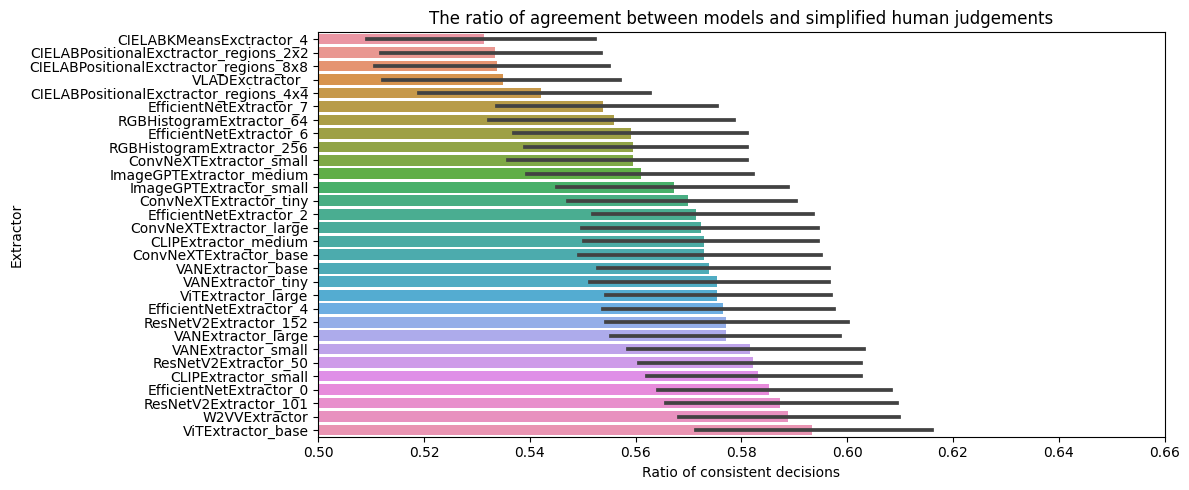

In [21]:
plt.figure(figsize=(15,6))
plt.title("The ratio of agreement between models and simplified human judgements")
sns.barplot(data = dfScores
            ,x="consistent",y="Extractor"
            , order=dfScores.groupby("Extractor")["consistent"].sum().sort_values().index)

fig = plt.gcf()
fig.set_size_inches(12, 5)

ax = plt.gca()
ax.set_xlabel("Ratio of consistent decisions")
ax.set_xlim(0.5,0.66)

#ax.set_xlim(0.0,humanAgreement+0.05)
#plt.vlines(x=humanAgreement, ymin=0, ymax=len(extractors)-1, color="red")

plt.tight_layout()
plt.savefig("img/overall_consistentRatio_aggregated_on_triplets.pdf")
plt.show()

- no substantial differences in ordering of methods
    - but overall inferior results (not so surprising - ignoring disent voices)
- agreement still considerably below the level of human agreement

# Correlation with detailed judgements
- judgements are considered as numeric values from -2 to +2 corresponding to a 5-point likert scale
- models are treated w.r.t. difference in the distance of respective candidates

In [22]:
dfAll["candidate1_preference"] = 0
dfAll.loc[dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = -dfAll.choice
dfAll.loc[~dfAll.candidate1DisplayedOnLeft, "candidate1_preference"] = dfAll.choice
#positive values indicate that users prefered candidate1 as more similar to query

In [23]:
columnsToDrop = []
minDistance = 1e-5
for extractor in extractors:
    col1 = extractor+"_cosdist_query_candidate1"
    col2 = extractor+"_cosdist_query_candidate2"
    opts = extractor+"_cosdist_candidates"
    dfAll.loc[dfAll[opts]==0,opts] = minDistance # fixing division by zero
    
    #positive values indicate that candidate1 is more similar than candidate2 (i.e., had lower distance)
    dfAll["distance_diff_"+extractor] = (dfAll[col2] - dfAll[col1])
    dfAll["distance_diff_maxNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[[col1, col2]].max(axis=1)
    dfAll["distance_diff_optionsDiffNorm"+extractor] = (dfAll[col2] - dfAll[col1])/dfAll[opts]

In [24]:
from scipy.stats import pearsonr, spearmanr

resultsDistanceDiff = {}
resultsDistanceDiffNorm = {}
resultsDistanceDiffOptNorm = {}

for extractor in extractors:
    resultsDistanceDiff[extractor] = pearsonr(dfAll["distance_diff_"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffNorm[extractor] = pearsonr(dfAll["distance_diff_maxNorm"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffOptNorm[extractor] = pearsonr(dfAll["distance_diff_optionsDiffNorm"+extractor],dfAll["candidate1_preference"])[0]

dfPearsonCorrelationResults = pd.DataFrame([resultsDistanceDiff,resultsDistanceDiffNorm,resultsDistanceDiffOptNorm],index=["distanceDiff","maxNormalizedDistanceDiff","optionsDistanceNormalizedDiff"]).T
dfPearsonCorrelationResults.sort_values("distanceDiff")

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABPositionalExctractor_regions_2x2,0.093208,0.134229,0.073539
CIELABKMeansExctractor_4,0.100797,0.119190,0.078363
VLADExctractor_,0.108438,0.127309,0.119643
CIELABPositionalExctractor_regions_4x4,0.116217,0.162360,0.123039
CIELABPositionalExctractor_regions_8x8,0.127471,0.169736,0.133597
ImageGPTExtractor_small,0.144162,0.192925,0.138069
ImageGPTExtractor_medium,0.148584,0.198313,0.150025
RGBHistogramExtractor_64,0.150855,0.167895,0.143239
RGBHistogramExtractor_256,0.154887,0.166447,0.147079
CLIPExtractor_small,0.235455,0.291629,0.257456


In [25]:
dfPearsonCorrelationResults.mean()

distanceDiff                     0.255788
maxNormalizedDistanceDiff        0.276045
optionsDistanceNormalizedDiff    0.257997
dtype: float64

In [26]:
resultsDistanceDiff = {}
resultsDistanceDiffNorm = {}
resultsDistanceDiffOptNorm = {}
from scipy.stats import pearsonr
for extractor in extractors:
    resultsDistanceDiff[extractor] = spearmanr(dfAll["distance_diff_"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffNorm[extractor] = spearmanr(dfAll["distance_diff_maxNorm"+extractor],dfAll["candidate1_preference"])[0]
    resultsDistanceDiffOptNorm[extractor] = spearmanr(dfAll["distance_diff_optionsDiffNorm"+extractor],dfAll["candidate1_preference"])[0]

dfSpearmanCorrelationResults = pd.DataFrame([resultsDistanceDiff,resultsDistanceDiffNorm,resultsDistanceDiffOptNorm],index=["distanceDiff","maxNormalizedDistanceDiff","optionsDistanceNormalizedDiff"]).T
dfSpearmanCorrelationResults.sort_values("distanceDiff")

,distanceDiff,maxNormalizedDistanceDiff,optionsDistanceNormalizedDiff
CIELABKMeansExctractor_4,0.102976,0.119171,0.093520
CIELABPositionalExctractor_regions_2x2,0.108302,0.141963,0.106030
VLADExctractor_,0.114989,0.125760,0.120522
CIELABPositionalExctractor_regions_4x4,0.127656,0.161817,0.138092
CIELABPositionalExctractor_regions_8x8,0.134700,0.164611,0.145132
RGBHistogramExtractor_64,0.149256,0.165705,0.149092
RGBHistogramExtractor_256,0.151057,0.162621,0.151738
ImageGPTExtractor_small,0.160660,0.204848,0.167865
ImageGPTExtractor_medium,0.164475,0.208201,0.177088
CLIPExtractor_small,0.253024,0.281127,0.265047


In [27]:
dfSpearmanCorrelationResults.mean()

distanceDiff                     0.242685
maxNormalizedDistanceDiff        0.255131
optionsDistanceNormalizedDiff    0.245246
dtype: float64

Notable observations:
- all evaluated extractors correlate with detailed human judgements to some extent (stat. sign in vast majority of cases)
- nonetheless, the correlation is weak for all evaluated options (at most 0.36)
- the best results were received for distance differences normalized by the larger of the two distances

### If the correlation between human and model is rather weak, what about correlations between models themselves?

In [28]:
cnames=[]
for extractor in extractors:
    cnames.append("distance_diff_maxNorm"+extractor)
dfModelsDistanceDiff = dfAll[cnames]
dfModelsDistanceDiff.shape

(17026, 30)

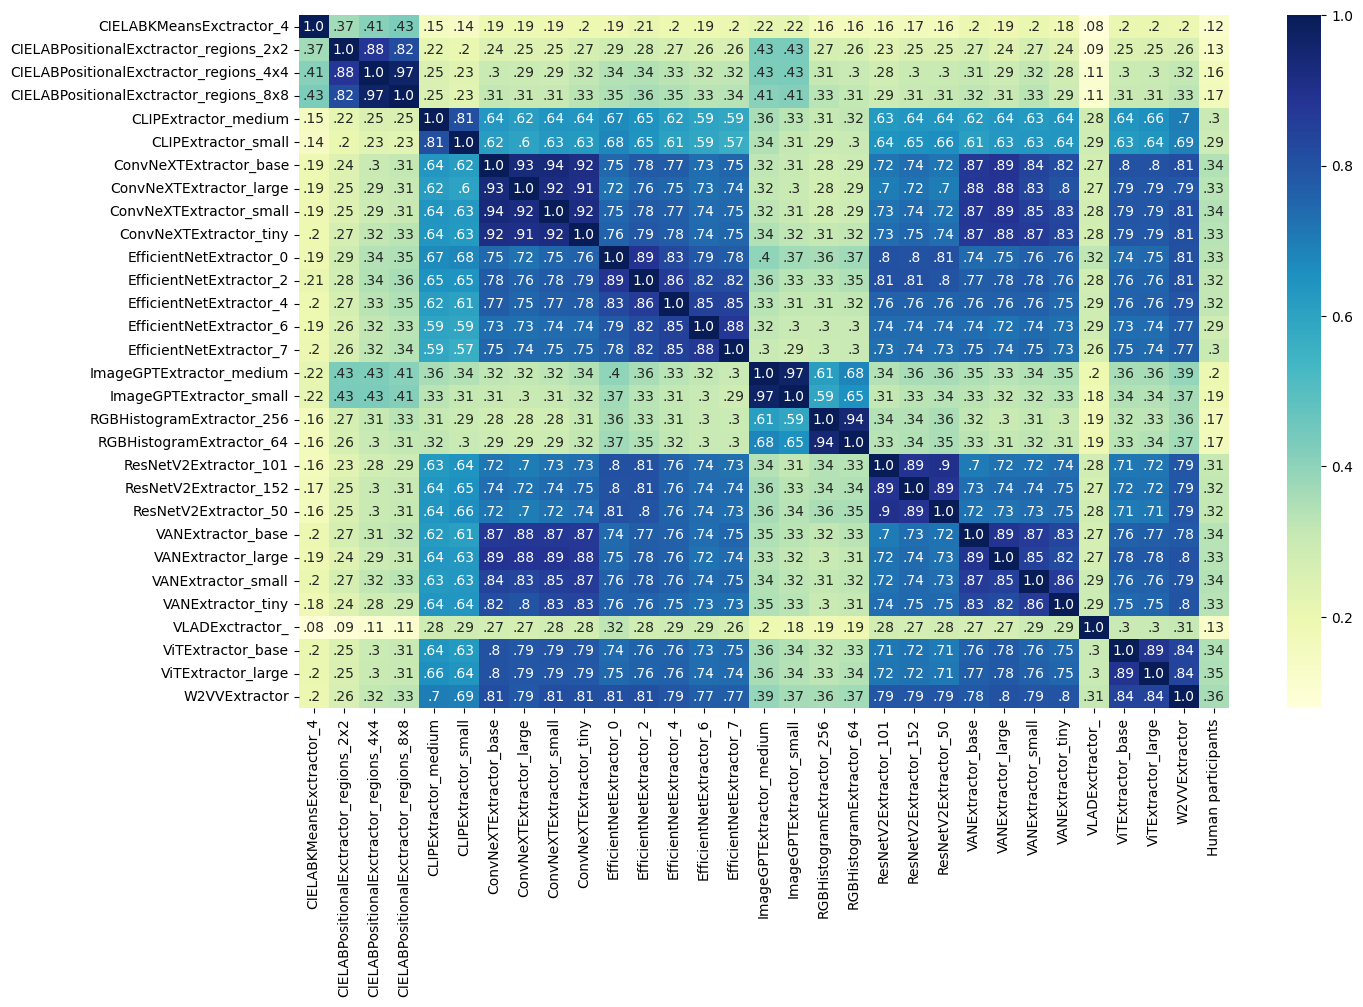

In [29]:
corrDF = dfModelsDistanceDiff.corr()
corrDF.columns = corrDF.columns.str.replace("distance_diff_maxNorm","")
corrDF.index = corrDF.index.str.replace("distance_diff_maxNorm","")
corrDF["Human participants"] = dfPearsonCorrelationResults["maxNormalizedDistanceDiff"]
annot_arr = np.around(corrDF.values,2).astype('str')
annot_arr = np.char.replace(annot_arr,"0.",".")
plt.figure(figsize=(15,9))
sns.heatmap(corrDF,  cmap="YlGnBu", annot=annot_arr, fmt="s")
plt.savefig("overall_correlationmatrix.pdf")

Highlights:
- much larger correlations among models than model-human
- different sizes of the same model usually very high correlation
- all DL approaches correlate with each other (except for ImageGPT, where lower layers were utilized)